In [1]:
from dotenv import load_dotenv

load_dotenv()

True

#### Agentes - Herramientas

In [2]:
import os
from typing import Literal

import requests
from langchain_anthropic import ChatAnthropic  # noqa
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_ollama import ChatOllama  # noqa

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode

In [3]:
@tool(name_or_callable="get_weather")
def get_weather(city: str):
    """tool que obtiene el clima de una ciudad"""

    WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")

    resp = requests.get(
        f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{city}/today?unitGroup=metric&include=current&key={WEATHER_API_KEY}&contentType=json"
    )

    return resp.json()


tools = [get_weather]

In [4]:
model = ChatAnthropic(model_name="claude-3-haiku-20240307", temperature=0)
final_model = ChatAnthropic(model_name="claude-3-haiku-20240307", temperature=0)

# model = ChatOllama(model="llama3.1", temperature=0)
# final_model = ChatOllama(model="llama3.1", temperature=0)

In [5]:
model = model.bind_tools(tools)
final_model = final_model.with_config(tags=["final_node"])

tool_node = ToolNode(tools=tools)

In [6]:
def call_model(state: MessagesState):
    messages = state["messages"]

    # system_prompt = ""
    # messages = [{"role": "system", "content": system_prompt}] + state["messages"]

    response = model.invoke(messages)

    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", "final"]:
    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        return "tools"

    return "final"


def call_final_model(state: MessagesState):
    messages = state["messages"]
    last_ai_message = messages[-1]

    response = final_model.invoke([
        SystemMessage(
            """
            Eres un asistente experto en clima que responde preguntas sobre el estado del tiempo de manera breve y precisa. Cada vez que informes sobre el clima, proporciona los siguientes detalles:

            1- Condiciones climáticas actuales (soleado, lluvioso, nublado, etc.).
            2- Temperatura en grados Celsius.
            3- Una sugerencia de vestimenta adecuada para el día (considerando las condiciones climáticas y la temperatura).
            
            Tu respuesta debe ser clara, corta y práctica.
            
            La respuesta debe ser en el siguiente formato:
            
            "El clima en [ciudad] es [condiciones climáticas]. La temperatura es de [temperatura] grados Celsius. Te recomiendo que te pongas [ropa recomendada]."
            """
        ),
        HumanMessage(last_ai_message.content),
    ])

    response.id = last_ai_message.id

    return {"messages": [response]}

In [7]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("final", call_final_model)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", "agent")
workflow.add_edge("final", END)

graph = workflow.compile()

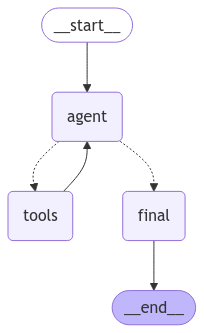

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

#### Prueba

In [9]:
for chunk in graph.stream(
    {"messages": [("human", "santiago de chile")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

santiago de chile
================================== Ai Message ==================================

[{'id': 'toolu_01Dp59kFac6AWoQuCirDTX7A', 'input': {'city': 'santiago de chile'}, 'name': 'get_weather', 'type': 'tool_use'}]
Tool Calls:
  get_weather (toolu_01Dp59kFac6AWoQuCirDTX7A)
 Call ID: toolu_01Dp59kFac6AWoQuCirDTX7A
  Args:
    city: santiago de chile
================================= Tool Message =================================
Name: get_weather

{"queryCost": 1, "latitude": -33.4372, "longitude": -70.65, "resolvedAddress": "Santiago, Región Metropolitana de Santiago, Chile", "address": "santiago de chile", "timezone": "America/Santiago", "tzoffset": -3.0, "days": [{"datetime": "2025-01-27", "datetimeEpoch": 1737946800, "tempmax": 33.4, "tempmin": 18.6, "temp": 24.5, "feelslikemax": 31.0, "feelslikemin": 18.6, "feelslike": 23.8, "dew": 6.3, "humidity": 34.3, "precip": 0.0, "precipprob": 0.0, "p